# MAC0219 - Programação Concorrente, Paralela e Distribuída
# EP2: CUDA & OpenMPI


| Nome | NUSP |
|------|------|
| Caio Andrade | 9797232 |
| Caio Fontes | 10692061 |
| Eduardo Laurentino | 8988212 |
| Thiago Teixeira | 10736987 |
| Washington Meireles | 10737157 |

Neste relatório, temos como objetivo explicar como foram feitas as nossas implementações do cálculo do Conjunto de Mandelbrot para as diferentes metodologias de paralelização, explicar como foram realizados os experimentos com essas implementações e analisarmos os resultados obtidos. 

Os arquivos-fonte de todas as implementações foram fornecidos junto a este relatório, bem como o arquivo makefile que possibilita todas as compilações. Além disso, fornecemos ainda um script em Pyhton ( _run_experiments.py_ ) que, quando executado, realiza uma rodada de experimentos para todas as versões por nós implementadas seguindo as configurações indicadas no enunciado: $15$ **repetições** da geração de uma imagem de **tamanho** $4096$ da região **Triple Spiral Valley**. Tal script gera, ao final, arquivos .csv com os resultados dos experimentos. 

Durante este relatório, utilizamos as duas funções abaixo para importar e processar as informações dos arquivoc csv que obtimos com os nossos experimentos, executados na Rede Linux. Todos estes arquivos foram também fornecidos. 

In [88]:
using DataFrames, Query, StatsPlots, Statistics, CSV

In [141]:
function parse_results(results, tipo)
    if tipo == "ompi_ompT"
        parsed_results = results |>
                        @groupby({_.threads,}) |>
                        @map({threads = key(_).threads,
                              mean_duration = mean(_.duration),
                              ci_duration = 1.96 * std(_.duration)}) |>
                        DataFrame
        
    elseif tipo == "pthreads"
        parsed_results = results |>
                        @groupby({_.threads,}) |>
                        @map({threads = key(_).threads,
                              mean_duration = mean(_.duration),
                              ci_duration = 1.96 * std(_.duration)}) |>
                        DataFrame
    elseif tipo == "omp"
        parsed_results = results |>
                        @groupby({_.threads,}) |>
                        @map({threads = key(_).threads,
                              mean_duration = mean(_.duration),
                              ci_duration = 1.96 * std(_.duration)}) |>
                        DataFrame
    elseif tipo == "ompi_ompP"
        parsed_results = results |>
                        @groupby({_.processes,}) |>
                        @map({processes = key(_).processes,
                              mean_duration = mean(_.duration),
                              ci_duration = 1.96 * std(_.duration)}) |>
                        DataFrame
    elseif tipo == "ompi"
            parsed_results = results |>
                        @groupby({_.processes,}) |>
                        @map({processes = key(_).processes,
                              mean_duration = mean(_.duration),
                              ci_duration = 1.96 * std(_.duration)}) |>
                        DataFrame
    elseif tipo == "cuda"
            parsed_results = results |>
                    @groupby({_.dimensions,}) |>
                    @map({dimensions = key(_).dimensions,
                          mean_duration = mean(_.duration),
                          ci_duration = 1.96 * std(_.duration)}) |>                    
                    DataFrame
    elseif tipo == "ompi_cudaP"
            parsed_results = results |>
                    @groupby({_.processes,}) |>
                        @map({processes = key(_).processes,
                              mean_duration = mean(_.duration),
                              ci_duration = 1.96 * std(_.duration)}) |>
                        DataFrame
    elseif tipo == "ompi_cudaD"
            parsed_results = results |>
                    @groupby({_.dimensions,}) |>
                        @map({dimensions = key(_).dimensions,
                              mean_duration = mean(_.duration),
                              ci_duration = 1.96 * std(_.duration)}) |>
                        DataFrame
    end
            

    return parsed_results
end

parse_results (generic function with 1 method)

In [107]:
function read_csv_results(filename)
    return CSV.read(filename)
end

read_csv_results (generic function with 1 method)

# 1. Implementação em CUDA

A implementação em CUDA foi feita tendo como base a versão sequencial, a qual adaptamos para as necessidades da paralelização com computação heterogênea, como é o caso aqui. Nesse sentido, transformamos o método `void compute_mandelbrot()` num método global, pois é este o **Kernel** do programa - isto é, a função que conecta o _Host_ (CPU) com o _Device_ (GPU). Além disso, deixamos os métodos que são utilizados somente durante o processamento dos pixels (à saber, `int mandelbrot()` e `void update_rgb_buffer()`) como exclusivas para o _device_. O restante das conexões entre as duas camadas de memória, _Host_ e _Device_ , foi feito manipulando adequadamente a alocação e tráfego de memória quando e onde necessário. 

A divisão de tarefas é feita de maneira estática à partir das dimensões dos _Blocos_ e do _Grid_ no qual estes estão inseridos. Para que pudessemos determinar experimentalmente os melhores valores para essas dimensões, o programa solicita como argumento (além das coordenadas da região do conjunto e o tamanho da imagem) as dimensões $(x, y)$ dos blocos. À partir desses valores, determina-se também as dimensões do _Grid_ de forma a garantir que a divisão das tarefas contemple toda a imagem a ser gerada. No caso da nossa implementação, isso significa atribuir ao _Grid_ dimensões $(\frac{image\_size}{x}, \frac{image\_size}{y})$. 

Dessa forma, fica estabelecido que cada pixel $(i_x, i_y)$ da imagem será tratado por uma _thread_ de identidade determinada pela sua posição num determinado bloco do grid de acordo com as especificações abaixo:

$$
i_x = blockIdx.x*blockDim.x+threadIdx.x \\
i_y = blockIdx.y*blockDim.y+threadIdx.y
$$

É importante observar uma condição de execução crucial relativa a essa implementação: devemos ter, necessariamente, $x * y \leq 1024$. Isso pois ao determinarmos as dimensões dos blocos como sendo $(x, y)$, isso significa que a quantidade de _threads_ em cada bloco é igual a $x * y$. O limite de $1024$ _threads_ por bloco é uma condição própria do desenvolvimento em CUDA.

## 1.1 Experimentos com CUDA

O objetivo aqui é realizar experimentos para diferentes valores dos parâmetros $x$ e $y$, que determinam a dimensão dos blocos e, por conseguinte, do _grid_. Para tanto, determinamos uma região de interesse para esses parâmetros cujo principal critério de escolha foi garantir que mantivéssemos $x * y \leq 1024$, conforme explicado anteriormente. Nesse sentido, decidimos começar com blocos de dimensao unica (isto é, uma única thread por bloco, implicando num grid com $image\_size * image\_size$ blocos) e irmos dobrando até $(32, 32)$, onde têm-se em cada bloco o limite de $1024$ threads, com _grid_ de dimensão $(128, 128)$. 

A **região de interesse** final, com a qual realizamos os experimentos, é:

**Dimensões dos blocos:** $(1,1)$, $(2,2)$, $(4,4)$, $(8,8)$, $(16,16)$ e $(32,32)$ 

**Respectivas dimensoes do _grid_ :** $(4096, 4096)$, $(2048, 2048)$, $(1024, 1024)$, $(512, 512)$, $(256, 256)$ e $(128, 128)$ 

Os resultados dos experimentos estão no arquivo _cuda_experiments.csv_ , que importamos abaixo:

In [144]:
experiments_cuda = read_csv_results("cuda_experiments.csv")

,dimensions,duration
,String,Float64
1,"2, 2",18.4867
2,"2, 2",17.6385
3,"2, 2",17.6688
4,"2, 2",17.6069
5,"2, 2",17.6232
6,"2, 2",17.6025
7,"2, 2",17.606
8,"2, 2",17.7131
9,"2, 2",17.7515


Com estes resultados, podemos obter o tempo médio de execução e os respectivos intervalos de confiança para cada parâmetro da nossa região de interesse, conforme abaixo:

In [145]:
final_results_cuda = parse_results(experiments_cuda, "cuda")

,dimensions,mean_duration,ci_duration
,String,Float64,Float64
1,"2, 2",17.6899,0.440795
2,"4, 4",4.52136,0.356347
3,"8, 8",2.27246,0.0727005
4,"16, 16",2.28517,0.144487
5,"32, 32",2.27029,0.0068397


# 2. Implementação em OMPI

A implementação em OMPI também teve como base a implementação sequencial do programa, que foi adequada para a paralelização através da troca de mensagens. Para este fim, a função `compute_mandelbrot` foi adaptada para receber parâmetros adicionais e uma função responsável por gerenciar a troca de mensagens - `compute_mandelbrot_ompi`- foi criada. Iremos explicar a implementação descrevendo o que é feito pelo processo principal (de rank 0, também chamado de `MASTER` no código) e pelos processos auxiliares.

**Processo Principal:**

No processo principal, primeiramente são inicializadas várias variáveis globais e os tipos de dados a serem utilizados pelas mensagens são definidos. Logo a seguir, o processo realiza a inicialização e os cálculos dos parametros a serem passados a cada outro processo para definir em que região da imagem ele irá trabalhar. 

A imagem é dividida em quadrantes com lado de tamanho $(image\_size\div\sqrt{n})+ 1$ arredondado para um número inteiro, onde $n$ é o número de processos que realizam trabalho, o último processo sempre se torna responsável por toda a parte restante quando chega o momento de definir o seu trabalho, em situações normais isso equivale a apenas mais um quadrante. Se toda a imagem já tiver sido atribuída e ainda tivermos processos restantes eles não realizam nenhuma computação. O intuito dessa divisão é garantir que toda a imagem seja coberta com qualquer número de processos e para qualquer tamanho de imagem, mesmo que certa ineficiências ocorram na divisão.

O processo principal então manda mensagens para todos os processos auxiliares com os valores que definem as coordenadas de começo e término da região que cada um deverá processar. Em seguida ele espera os processos terminarem a computação.

O processo principal então recebe um vetor 1D com os valores de $x$,$y$ e $iterations$ para cada pixel, e uma variável `count` indicando o tamanho desse vetor. Depois de receber os resultados de todos processos o processo principal transfere os valores para a imagem determinado as cores correspondentes.

**Processos Auxiliares**

Os processos auxiliares realizam o mesmo processo de inicialização das variáveis globais e dos tipos de dados. Depois disso esperam, através da chamada `MPI_Recv` uma mensagem do processo principal definindo a sua região da imagem.

Em outras palavras, fizemos uma divisão de trabalho entre processo principal e processos auxiliares de forma que o processo principal ficou encarregado de **gerenciar** o trabalho que cada processo auxiliar executa, ou seja, ele é encarregado de fazer a divisão de trabalho, inicializar variáveis e orquestrar o trabalho entre os processos auxiliares, **enviando** trechos da imagem que cada processo deverá calcular e **recebendo** o resultado, e consequentemente montando a imagem resultado. Os processos auxiliares simplesmente calculam como sua região da imagem deve ser colorida e enviam para o processo principal.

## 2.1 Experimentos com OMPI

O objetivo é determinar um número ideal $n$ de processos para a implementação através desses experimentos. Definimos a região de interesse conforme sugestão do enunciado, mas sempre tendo pelo menos um processo principal que coletasse os resultados, sendo assim a **região de interesse** com que realizamos os experimentos foi:


**Número de Processos:** $1$, $2$, $3$, $5$, $9$, $17$, $33$, $65$

Os resultados dos experimentos estão no arquivo _ompi_experiments.csv_ , que importamos abaixo:

In [8]:
experiments_ompi = read_csv_results("ompi_experiments.csv")

,processes,duration
,Int64,Float64
1,2,26.728
2,2,26.6555
3,2,26.8371
4,2,26.7633
5,2,26.6282
6,2,26.9056
7,2,26.6655
8,2,26.6208
9,2,26.8538


Com estes resultados, podemos obter o tempo médio de execução e os respectivos intervalos de confiança para cada parâmetro da nossa região de interesse, conforme abaixo:

In [109]:
final_results_ompi = parse_results(experiments_ompi, "ompi") 

,processes,mean_duration,ci_duration
,Int64,Float64,Float64
1,2,26.7508,0.215736
2,3,26.7096,0.198727
3,5,9.23427,0.192052
4,9,9.45713,0.452817
5,17,4.68719,0.367088
6,33,4.10299,0.438417
7,65,4.25879,0.279031


# 3. Implementação em OMPI + OMP

Nessa implementação, mantivemos a estrutura de comunicação definida na implementação com OMP e alteramos como cada processo auxiliar processa sua região da imagem: para calcular o número de iterações até a convergência de cada pixel, paralelizamos a computação por OpenMP. Para tanto, as mudanças ocorreram apenas na função `compute_mandelbrot`.


## 3.1 Experimentos com OMPI + OMP

Seguindo as instruções do enunciado, os experimentos foram feitos usando os seguintes parâmetros fixos: $15$ **repetições** da geração de uma imagem de **tamanho** $4096$ da região **Triple Spiral Valley**.

Os números de processos foram determinados da mesma maneira que na implementação em OMPI, para fins de equivalência dos experimentos. O número $t$ de threads varia entre 1 e 64 seguindo as potências de 2, afim de cobrir uma região grande, permitindo analisar o impacto desse parâmetro. Consideramos que valores maiores gerariam um overhead muito grande, tornando o experimento pouco informativo.


**Número de Processos:** $2$,$3$,$5$,$9$,$17$,$33$,$65$

**Número de Threads:** $1$,$2$,$4$,$8$,$16$,$32$,$64$

Os resultados dos experimentos estão no arquivo _ompi_omp_experiments.csv_ , que importamos abaixo:

In [110]:
experiments_ompi_omp = read_csv_results("ompi_omp_experiments.csv")

,processes,threads,duration
,Int64,Int64,Float64
1,2,1,27.295
2,2,1,27.309
3,2,1,27.2576
4,2,1,26.9724
5,2,1,26.9656
6,2,1,27.0364
7,2,1,27.0953
8,2,1,27.1699
9,2,1,27.0046


Com estes resultados, podemos obter o tempo médio de execução e os respectivos intervalos de confiança para cada parâmetro da nossa região de interesse. Dessa vez...

In [111]:
final_results_ompi_ompP = parse_results(experiments_ompi_omp, "ompi_ompP") 

,processes,mean_duration,ci_duration
,Int64,Float64,Float64
1,2,18.3726,7.15726
2,3,10.2651,15.4538
3,5,5.13035,3.9326
4,9,5.1402,3.95222
5,17,4.00897,0.678883
6,33,4.07133,0.420158
7,65,4.45106,0.596669


In [112]:
final_results_ompi_ompT = parse_results(experiments_ompi_omp, "ompi_ompT") 

,threads,mean_duration,ci_duration
,Int64,Float64,Float64
1,1,12.4603,18.9955
2,2,8.00885,9.71935
3,4,6.69923,8.59644
4,8,6.1308,8.84777
5,16,6.05688,8.98802
6,32,6.05356,9.01988
7,64,6.03004,9.06569


# 4. Implementação em OMPI + CUDA

Compilação:

## 4.1 Experimentos com OMPI + CUDA

**FALAR/JUSTITIFICAR DEFINIÇÃO DA REGIAO DE INTERESSE!**

In [ ]:
#definir regiao
dimensions = [(2,2),(4,4),(8,8),(16,16),(32,32)]
processes = [2,3,5,9,17,33,65]

In [ ]:
#funcao pra rodar experimentos nessa regiao


In [ ]:
#funcao pra rodar experimentos nessa regiao

In [ ]:
#rodar os experimentos e salvar em csv 

In [112]:
#ler o csv e gerar o parser com medias e CIs
experiments_ompi_cuda = read_csv_results("ompi_cuda_experiments.csv")
final_results_ompi_cudaP = parse_results(experiments_ompi_cuda, "ompi_cudaP")
final_results_ompi_cudaD = parse_results(experiments_ompi_cuda, "ompi_cudaD")


,dimensions,mean_duration,ci_duration,ci_value1,ci_value2
,String,Float64,Float64,Float64,Float64
1,"2, 2",4.07654,3.809,5.98104,2.17204
2,"4, 4",4.0773,3.75796,5.95628,2.19832
3,"8, 8",4.08186,3.80942,5.98657,2.17715
4,"16, 16",4.05269,3.73621,5.92079,2.18459
5,"32, 32",4.09374,3.82726,6.00737,2.18011


# 5. Análise dos resultados dos experimentos

Faremos uso das duas funções abaixo para gerar os gráficos sobre os quais analisaremos cada caso:

In [121]:
function plot_results(x, y1, series_label, xlabel_, ylabel_, title_, yerror)
    if yerror == []
        p = scatter(x, y1,
        alpha = 0.6,
        labels = series_label,
        xlabel = xlabel_,
        ylabel = ylabel_,
        title = title_,
        legend = :topright)

        return p  
    end
    
    p = plot(x,        
            y1,
            yerror = yerror,
            alpha = 0.9,
            labels = series_label,
            xlabel = xlabel_,
            ylabel = ylabel_,
            title = title_,
            color = "red",
            seriestype = :scatter,
            lw = 1,
            legend = :topright)
    
    return p   
end

plot_results (generic function with 2 methods)

In [122]:
function plot_results_histogram(x, y, series_label, xlabel_, ylabel_, title_)      
    p = histogram(x, y,
            alpha = 0.6,
            labels = series_label,
            xlabel = xlabel_,
            ylabel = ylabel_,
            title = title_,
            legend = :topright)
    return p
end

plot_results_histogram (generic function with 1 method)

## 5.1 Resultados da versão CUDA

[ANALISE GERAL]


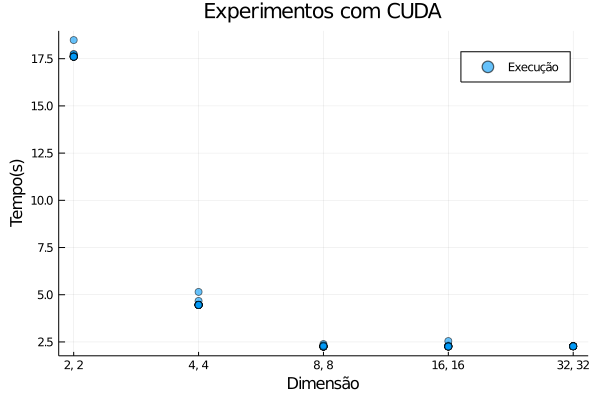

In [151]:
plot_results(experiments_cuda.dimensions, experiments_cuda.duration, "Execução", "Dimensão", "Tempo(s)", "Experimentos com CUDA", [])

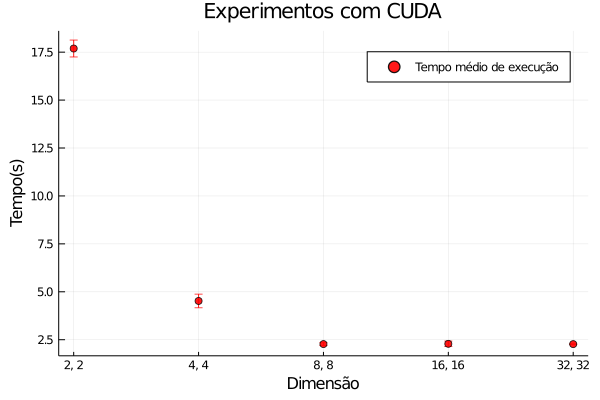

In [152]:
plot_results(final_results_cuda.dimensions,
    final_results_cuda.mean_duration,    
    "Tempo médio de execução", "Dimensão", "Tempo(s)", "Experimentos com CUDA", 
    final_results_cuda.ci_duration)

**ESCOLHER E JUSTIFICAR OS MELHORES PARAMETROS!**

## 5.2 Resultados da versão OMPI

[ANALISE GERAL]


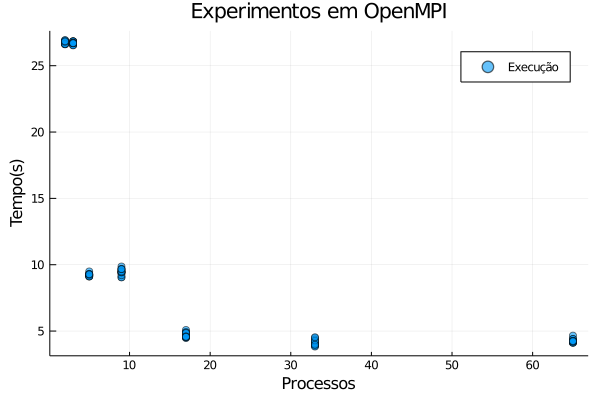

In [126]:
#plotar graficos com todos os pontos
plot_results(experiments_ompi.processes, experiments_ompi.duration, "Execução", "Processos", "Tempo(s)", "Experimentos em OpenMPI")

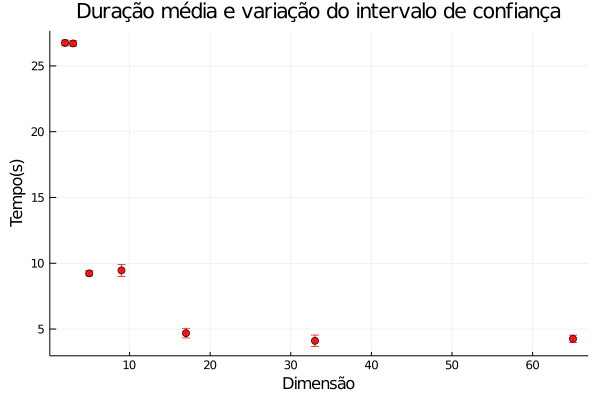

In [128]:
#plotar graficos com tempo medio e intervalo de confiança
plot_results(final_results_ompi.processes,
    final_results_ompi.mean_duration,    
    "", "Dimensão", "Tempo(s)", "Duração média e variação do intervalo de confiança", final_results_ompi.ci_duration)


**ESCOLHER E JUSTIFICAR OS MELHORES PARAMETROS BASEANDO-SE NOS GRAFICOS!**

## 5.3 Resultados da versão OMPI + OMP

[ANALISE GERAL]



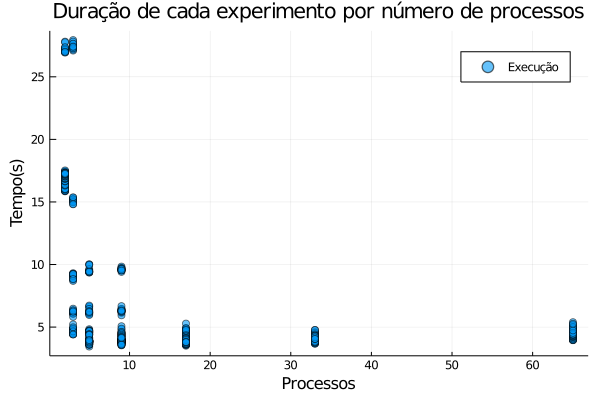

In [129]:
#plotar graficos com todos os pontos
plot_results(experiments_ompi_omp.processes,
    experiments_ompi_omp.duration,    
    "Execução", "Processos", "Tempo(s)", "Duração de cada experimento por número de processos")

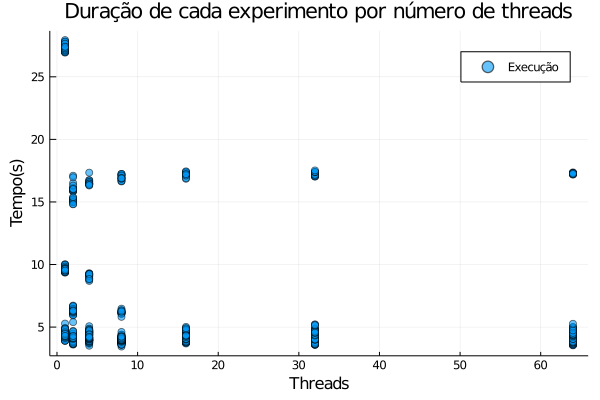

In [130]:
plot_results(experiments_ompi_omp.threads,
    experiments_ompi_omp.duration,    
    "Execução", "Threads", "Tempo(s)", "Duração de cada experimento por número de threads")

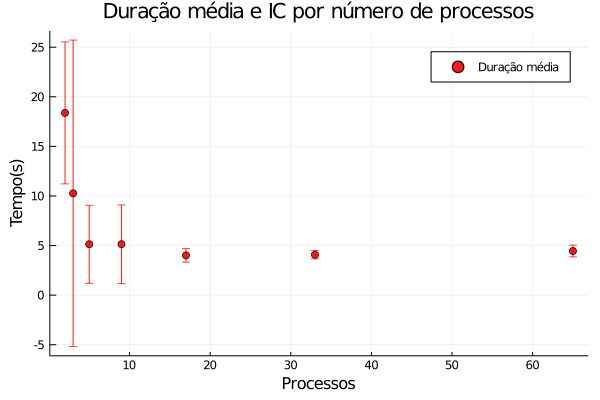

In [132]:
#plotar graficos com tempo medio e intervalo de confiança
plot_results(final_results_ompi_ompP.processes,
    final_results_ompi_ompP.mean_duration,    
    "Duração média", "Processos", "Tempo(s)", "Duração média e IC por número de processos", final_results_ompi_ompP.ci_duration)

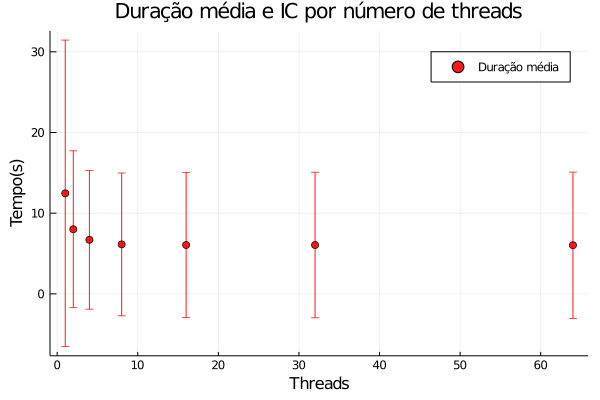

In [133]:
#plotar graficos com tempo medio e intervalo de confiança
plot_results(final_results_ompi_ompT.threads,
    final_results_ompi_ompT.mean_duration,    
    "Duração média", "Threads", "Tempo(s)", "Duração média e IC por número de threads", final_results_ompi_ompT.ci_duration)

**ESCOLHER E JUSTIFICAR OS MELHORES PARAMETROS BASEANDO-SE NOS GRAFICOS!**


## 5.4 Resultados da versão OMPI + CUDA

[ANALISE GERAL]


In [134]:
#plotar graficos com todos os pontos
plot_results(experiments_ompi_cuda.processes,
    experiments_ompi_cuda.duration,    
    "Execução", "Processos", "Tempo(s)", "Duração de cada experimento por número de processos")

UndefVarError: UndefVarError: experiments_ompi_cuda not defined

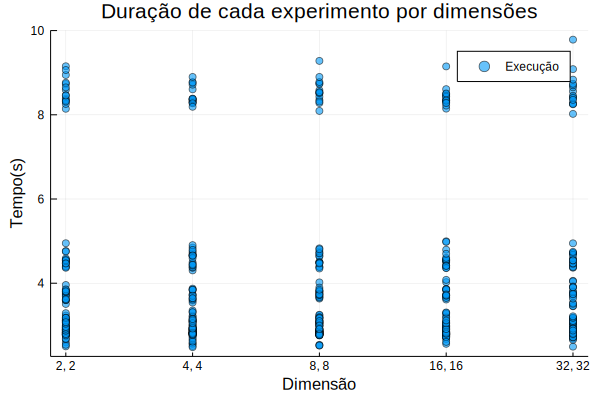

In [76]:
#plotar graficos com todos os pontos
plot_results(experiments_ompi_cuda.dimensions,
    experiments_ompi_cuda.duration,    
    "Execução", "Dimensão", "Tempo(s)", "Duração de cada experimento por dimensões")

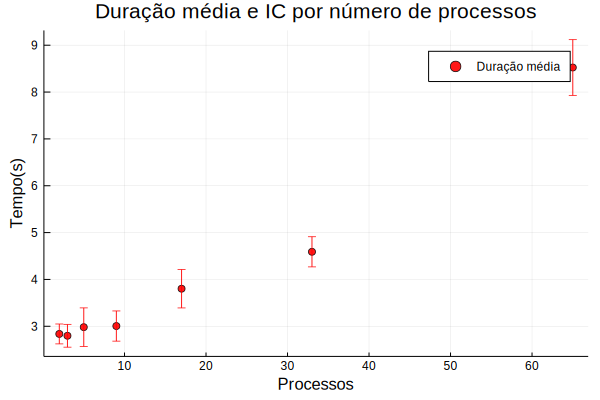

In [80]:
#plotar graficos com tempo medio e intervalo de confiança
plot_results_scatter(final_results_ompi_cudaP.processes,
    final_results_ompi_cudaP.mean_duration,    
    "Duração média", "Processos", "Tempo(s)", "Duração média e IC por número de processos", final_results_ompi_cudaP.ci_duration)

In [ ]:
#plotar graficos com tempo medio e intervalo de confiança


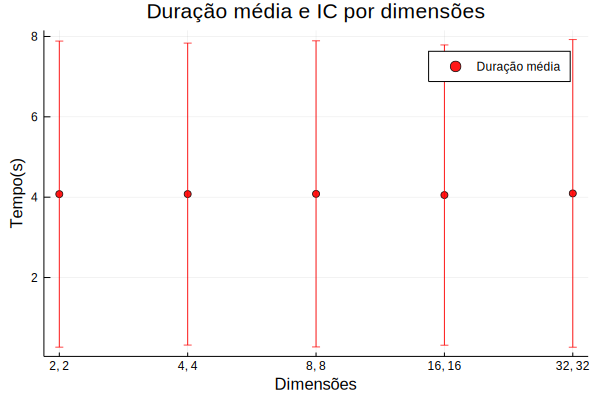

In [84]:
#plotar graficos com tempo medio e intervalo de confiança
plot_results_scatter(final_results_ompi_cudaD.dimensions,
    final_results_ompi_cudaD.mean_duration,    
    "Duração média", "Dimensões", "Tempo(s)", "Duração média e IC por dimensões", final_results_ompi_cudaD.ci_duration)

**ESCOLHER E JUSTIFICAR OS MELHORES PARAMETROS BASEANDO-SE NOS GRAFICOS!**



# 6. Resultados do EP1 seguindo o padrão do EP2

Para que possamos fazer uma analise comparativa entre todas as versões que desenvolvemos para o Cálculo do Conjunto de Mandelbrot, através do script _run_experiments.py_ executamos também experimentos relativos as versões entregues no EP1 (Sequencial, Pthreads e OpenMP) utilizando os mesmos parâmetros fixos considerados aqui: $15$ **repetições** da geração de uma imagem de **tamanho** $4096$ da região **Triple Spiral Valley**

Assim como nos casos anteriores, os arquivos .csv com os resultados destes experimentos foram fornecidos e nós os importamos abaixo:

### Sequencial:

In [135]:
experiments_sequencial = read_csv_results("seq_experiments.csv")

,duration
,Float64
1,27.5763
2,27.6554
3,28.2566
4,29.741
5,28.4806
6,29.4961
7,28.7576
8,28.2968
9,28.4506


In [96]:
final_results_sequencial = parse_results(experiments_sequencial)

MethodError: MethodError: no method matching parse_results(::DataFrame)
Closest candidates are:
  parse_results(::Any, !Matched::Any) at In[89]:2

### Pthreads:

In [136]:
experiments_pth = read_csv_results("pth_experiments.csv")

,threads,duration
,Int64,Float64
1,1,28.8056
2,1,28.3448
3,1,29.0453
4,1,29.394
5,1,28.1015
6,1,28.3721
7,1,28.5022
8,1,28.2636
9,1,29.1992


In [137]:
final_results_pth = parse_results(experiments_pth, "pthreads")

,threads,mean_duration,ci_duration
,Int64,Float64,Float64
1,1,28.8472,1.19163
2,2,26.7858,0.543657
3,4,14.0143,0.79504
4,8,8.89757,0.616525
5,16,5.42304,0.579045
6,32,3.6455,0.463688
7,64,3.42551,0.548569


### OpenMP:

In [138]:
experiments_omp = read_csv_results("omp_experiments.csv")

,threads,duration
,Int64,Float64
1,1,28.4714
2,1,29.1697
3,1,29.6925
4,1,28.6584
5,1,29.4521
6,1,28.7501
7,1,29.4946
8,1,28.8353
9,1,29.0405


In [142]:
final_results_omp = parse_results(experiments_omp, "omp")

,threads,mean_duration,ci_duration
,Int64,Float64,Float64
1,1,29.219,1.1909
2,2,14.7347,0.483159
3,4,8.56224,0.55287
4,8,5.55285,0.847721
5,16,4.11329,0.534923
6,32,3.25592,0.557335
7,64,3.24436,0.44773


# 7. Comparação entre as diferentes versões

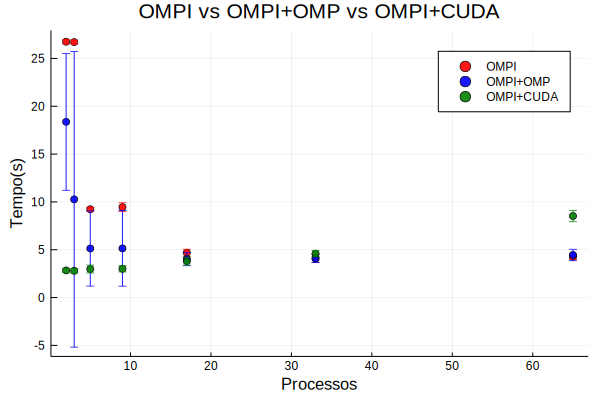

In [181]:
#==plotar graficos!!!
plot_resultsEP1(final_results_ompi.threads, final_results_omp.mean_duration, "OMPI", final_results_ompi.ci_duration, "Threads",
            final_results_ompi_ompT.mean_duration, "OMPI+OMP", final_results_ompi_ompT.ci_duration,
            final_results_ompi_cudaT.mean_duration, "OMPI+CUDA", final_results_ompi_cudaT.ci_duration,
            seq_tripleSpiral, "Sequencial", seq_tripleSpiral.ci_duration,
            pth_tripleSpiral, "Pthreads", pth_tripleSpiral.ci_duration,
            omp_tripleSpiral.mean_duration, "OMP", omp_tripleSpiral.ci_duration)
==#
plot_resultsEP1(final_results_ompi.processes, final_results_ompi.mean_duration, "OMPI", final_results_ompi.ci_duration, "Processos",
            final_results_ompi_ompP.mean_duration, "OMPI+OMP", final_results_ompi_ompP.ci_duration,
            final_results_ompi_cudaP.mean_duration, "OMPI+CUDA", final_results_ompi_cudaP.ci_duration,
            [], [], [],
            [], [], [],
            [], [], [], "OMPI vs OMPI+OMP vs OMPI+CUDA")


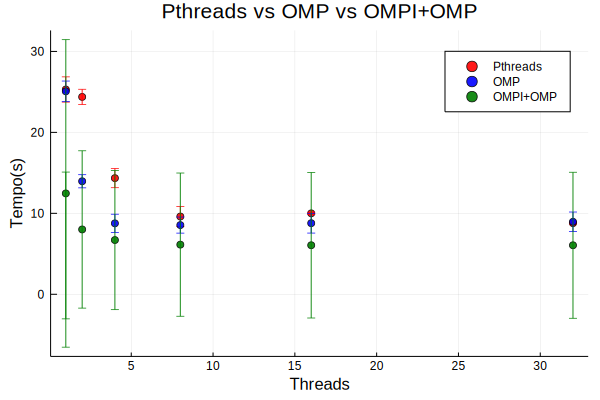

In [182]:
#plotar graficos!!!
plot_resultsEP1(pth_tripleSpiral.threads, pth_tripleSpiral.mean_duration, "Pthreads", pth_tripleSpiral.ci_duration, "Threads",
            omp_tripleSpiral.mean_duration, "OMP", omp_tripleSpiral.ci_duration,
            final_results_ompi_ompT.mean_duration, "OMPI+OMP", final_results_ompi_ompT.ci_duration,
            [], [], [],
            [], [], [],
            [], [], [], "Pthreads vs OMP vs OMPI+OMP")

In [124]:
#Apos escolher os melhores parametros, usar esse histograma para compará-los
plot_results_histogram(x, y, series_label, xlabel_, ylabel_, title_) 

***Usando os parâmetros determinados na seção anterior, comparar os desempenhos das seguintes versões do programa basenado-se nos graficos!!!!***


# 8. Conclusão